In [1]:
import tensorflow as tf
from tensorflow import keras

# ヘルパーライブラリのインポート
import numpy as np
import matplotlib.pyplot as plt

## データの読み込みとビジュアライズ

In [2]:
# データセットのインポート
fashion_mnist = keras.datasets.fashion_mnist
(train_x, train_y), (test_x, test_y) = fashion_mnist.load_data()

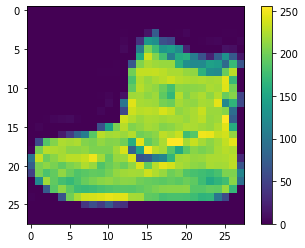

In [3]:
# 学習教師データには服や靴などの画像が含まれる
plt.figure()
plt.imshow(train_x[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [4]:
# 学習用教師ラベルには、「Tシャツ」「靴」などのカテゴリ番号が入る
# 番号は、以下のクラス名リストのインデックスに対応
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
# ラベル番号からクラス名に変換
class_names[train_y[0]]

'Ankle boot'

In [6]:
# 全部で幾つの学習用データが含まれるか
train_x.shape, train_y.shape

((60000, 28, 28), (60000,))

In [7]:
test_x.shape, test_y.shape

((10000, 28, 28), (10000,))

## データの前処理

In [8]:
# 0-1の範囲に入力データをスケーリングする
train_x = train_x / 255.0
test_x = test_x / 255.0

<Figure size 720x720 with 0 Axes>

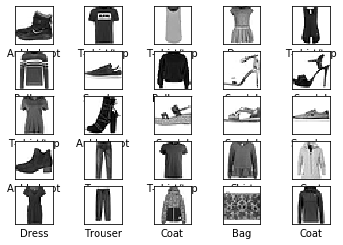

In [9]:
# 5x5のグリッドで、25枚のテスト画像を表示
plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(5, 5)
for row in range(5):
    for col in range(5):
        i = 5*row + col
        ax = axs[row][col]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(train_x[i], cmap=plt.cm.binary)
        ax.set_xlabel(class_names[train_y[i]])

## 単層ネットワークの構築と学習

In [10]:
#  学習モデルの定義
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)), # 入力層. 28x28の二次元配列を784の一次元配列にフォーマットする (何も学習していない)
    keras.layers.Dense(128, activation='relu'), # 中間全結合層. 活性化関数には勾配喪失問題に対応したReLUを使用
    keras.layers.Dense(10, activation='softmax'), # 出力層. 多分類のための出力設計としてsoftmaxを活性化関数に使用
])

In [11]:
# 学習手法の定義
model.compile(
    optimizer='adam', # 勾配を使ってどのように重みを更新するか
    loss='sparse_categorical_crossentropy', # 出力層の勾配をどのように計算するか (中間層の勾配は誤差逆伝搬法を使った自動微分で算出される)
    metrics=['accuracy'], # モデルの学習精度をどのような指標で計測するか
)

In [12]:
import datetime

# 学習ログをtensorboardで表示するためのログを残す
log_dir = "logs/single_layer_mnist/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [13]:
# 訓練 - バッチ学習(ミニではない)
model.fit(train_x, train_y, epochs=5, callbacks=[tensorboard_callback])

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 92us/sample - loss: 0.4956 - accuracy: 0.8246
Epoch 2/5
60000/60000 [==============================] - 6s 105us/sample - loss: 0.3754 - accuracy: 0.8637
Epoch 3/5
60000/60000 [==============================] - 5s 91us/sample - loss: 0.3360 - accuracy: 0.8778
Epoch 4/5
60000/60000 [==============================] - 4s 74us/sample - loss: 0.3132 - accuracy: 0.8857
Epoch 5/5
60000/60000 [==============================] - 5s 76us/sample - loss: 0.2948 - accuracy: 0.8915


In [16]:
# tensorboardを表示
%load_ext tensorboard
%tensorboard --logdir logs/single_layer_mnist

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## 単層ネットワークの評価

In [17]:
# テストデータを使った、汎化性能の精度評価
test_loss, test_acc = model.evaluate(test_x, test_y, verbose=2)

10000/1 - 1s - loss: 0.2786 - accuracy: 0.8747


↑model.fitで出力されたログに記載のaccuracyと比較すると、テストデータの方が精度が悪い。つまり、汎化性のない過学習を起こしている

## 学習済みネットワークを使った予測

In [18]:
# softmaxの定義通り、10クラスに属する各確率を配列で返す
preds = model.predict(test_x)
preds[0]

array([4.25279950e-07, 2.86920135e-06, 3.47336004e-06, 7.96919085e-06,
       1.13645996e-07, 1.12342192e-02, 1.56294641e-06, 1.68226123e-01,
       1.30967208e-04, 8.20392311e-01], dtype=float32)

In [19]:
# 最大の確率をとるクラス番号を取得
np.argmax(preds[0])

9

In [20]:
# 正解データと比較
test_y[0]

9

In [21]:
# 各クラスの予測と正解数のグラフを表示
# 参考 : https://www.tensorflow.org/tutorials/keras/classification
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

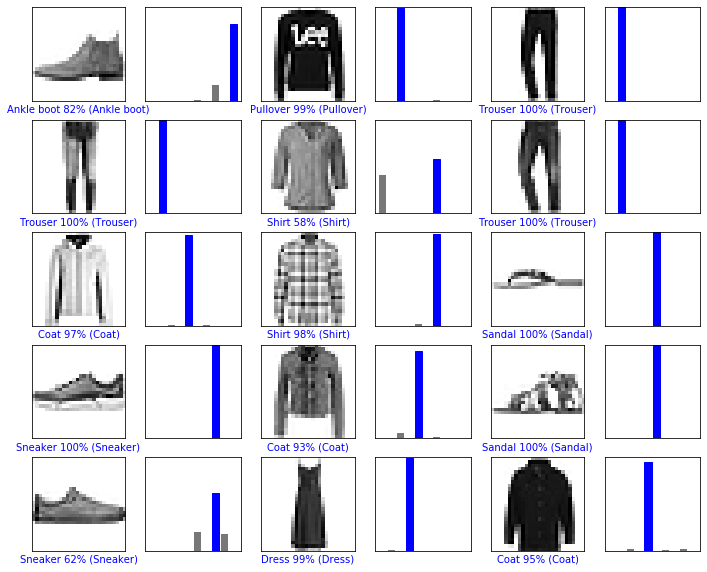

In [22]:
# X個のテスト画像、予測されたラベル、正解ラベルを表示します。
# 正しい予測は青で、間違った予測は赤で表示しています。
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, preds, test_y, test_x)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, preds, test_y)
plt.show()